In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


In [5]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "new york": "$999"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [7]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
tools = [{"type": "function", "function": price_function}]

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        print('\nmessage:', message)
        print('\nresponse:', response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [10]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


In [12]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import FileLink

In [13]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

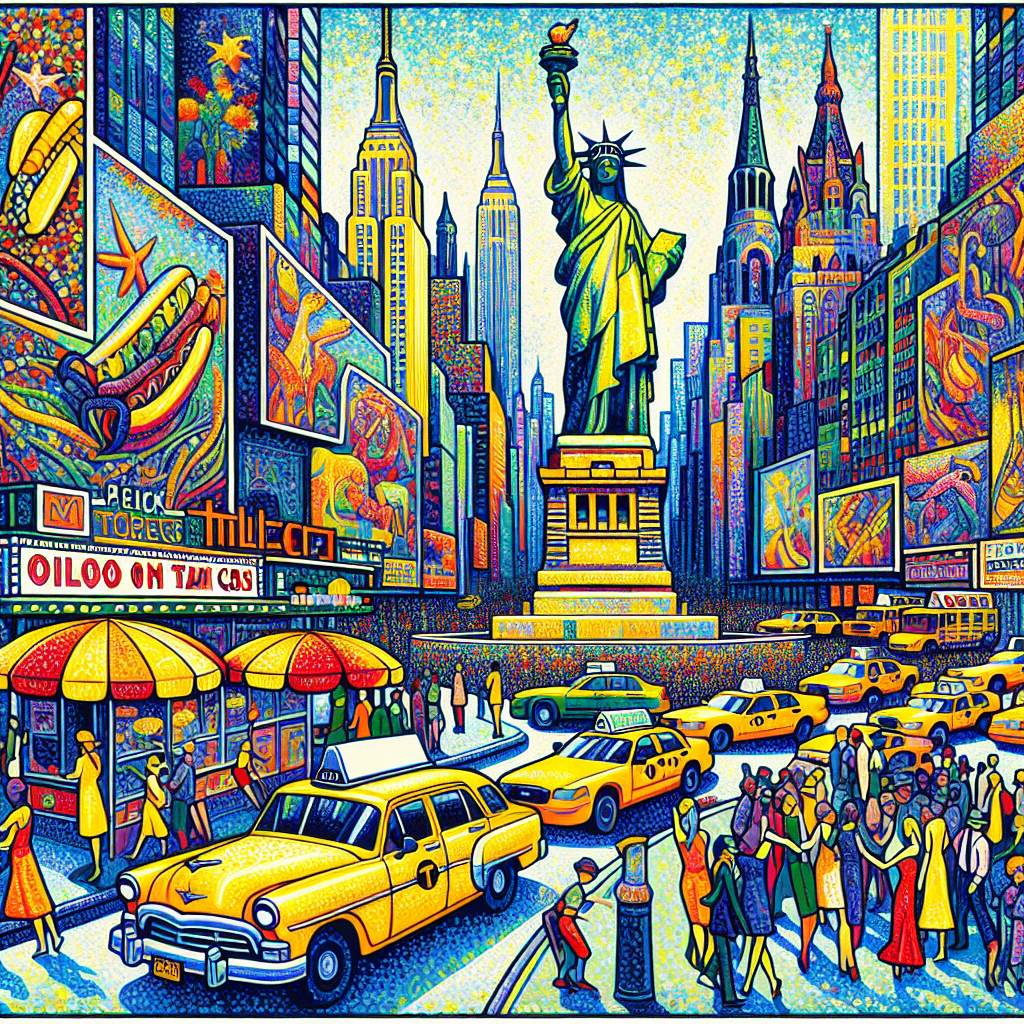

In [14]:
# generate image
# image = artist("New York City")
# display(image)

# load image
image = Image.open("image_new_york_city.png")
display(image)

In [15]:
file_path = "image_new_york_city.png"

# Save image
image.save(file_path)

# Create a downloadable link
FileLink(file_path)

C:\Users\Pavel\projects\llm-udemy\week2\image_new_york_city.png

In [16]:
# from IPython.display import Image

# # display image in notebook
# Image(filename='image_prague.webp')

In [17]:
# from PIL import Image
# import matplotlib.pyplot as plt

# # load image
# file_path = 'image_prague.webp'
# img = Image.open(file_path)

# # display image
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [18]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 4.1.1 Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 8.2.1 (GCC) 20190212
configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth
libavutil      56. 22.100 / 56. 22.100
libavcodec     58. 35.100 / 58. 35.100
libavform

In [19]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [20]:
# talker("Well, hi there")

In [21]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

# talker("Well hi there")

In [22]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # Set a custom directory for temporary files on Windows
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # You can also use 'TMP' if necessary
    
    # Create the folder if it doesn't exist
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

# talker("Well hi there")

In [23]:
# !pip install simpleaudio

In [24]:
# from pydub import AudioSegment
# from io import BytesIO
# import tempfile
# import os
# import simpleaudio as sa

# def talker(message):
#     response = openai.audio.speech.create(
#         model="tts-1",
#         voice="onyx",  # Also, try replacing onyx with alloy
#         input=message
#     )
    
#     audio_stream = BytesIO(response.content)
#     audio = AudioSegment.from_file(audio_stream, format="mp3")

#     # Create a temporary file in a folder where you have write permissions
#     with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
#         temp_file_name = temp_audio_file.name
#         audio.export(temp_file_name, format="wav")
    
#     # Load and play audio using simpleaudio
#     wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
#     play_obj = wave_obj.play()
#     play_obj.wait_done()  # Wait for playback to finish

#     # Clean up the temporary file afterward
#     os.remove(temp_file_name)
    
# # talker("Well hi there")

In [25]:
MODEL

'gpt-4o-mini'

In [26]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools
    )
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        # image = artist(city)
        image = Image.open("image_new_york_city.png")
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    # talker(reply)
    
    return history, image

In [27]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7882

To create a public link, set `share=True` in `launch()`.
